In [1]:
import numpy as np
import pandas as pd

바이크 셋의 데이터를 불러옵니다

In [129]:
data = pd.read_csv(r"C:\Users\302-28\git-repo\Dacon\kaggle\바이크\bike-sharing-demand\train.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


데이터는 datetime을 제외한 수치형으로 되어있으며 결측치는 없고 행이 10886개인 데이터입니다. 목적은 시간대별 자전거 대여 수 예측입니다. 일단 값을 예측해야하는 문제이기에 분류가 아닌 회귀로 풀어야 할것이고 여기서 시계열 데이터 전처리가 필요해 보입니다. 또한 데이터들 중 필요한 데이터들만 뽑아서 모델을 학습 하겠습니다. 
kaggle 홈페이지의 데이터 설명을 보면 각 특성들은 아래와 같습니다.

datetime - 매시간 날짜 + 타임스탬프  
season - 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울 
holiday - 해당 요일이 휴일로 간주되는지 여부
workingday - 해당 요일이 주말도 휴일도 아닌지 여부
weather - 1: 맑음, 구름 약간, 구름 약간, 구름 약간
2: 안개 + 구름, 안개 + 깨진 구름, 안개 + 구름 약간, 안개
3: 가벼운 눈, 가벼운 비 + 뇌우 + 흩어진 구름, 가벼운 비 + 흩어진 구름
4: 폭우 + 얼음판 + 뇌우 + 안개, 눈 + 안개 
temp - 섭씨 온도
atemp - "체감 온도" 섭씨
humid - 상대 습도
windspeed - 풍속
casual - 등록되지 않은은 사용자 대여가 시작된 수
registered - 등록된 사용자 대여가 시작된 수
count - 총 대여 수

여기서 count는 회귀로 예측할 값이라고 할 수 있습니다. test의 특성중에 casual, registered가 빠져있기에 학습 데이터에서도 제외시키겠습니다.

In [130]:
data.drop(['casual','registered'], axis = 1, inplace= True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   count       10886 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 850.6+ KB


그리고 시계열 데이터를 수치형으로 변경하겠습니다. 변경 코드는 베이스코드에 있는 코드를 사용하겠습니다. 아래의 코드는 시계열 데이터를 년,월,일,시간으로 나누고 새로운 특성으로 만드는 과정이고 그 과정에서 원래 datetime은 필요가 없어지기 때문에 제외시킵니다.

In [131]:
# 문자열을 datetime 타입으로 변경.
print(type(data['datetime']))
data['datetime'] = data.datetime.apply(pd.to_datetime) # 문자열로 되있다면 관련 로그가 출력되지 않는다.
# datetime 타입에서 년, 월, 일, 시간 추출
data['year'] = data.datetime.apply(lambda x : x.year)
data['month'] = data.datetime.apply(lambda x : x.month)
data['day'] = data.datetime.apply(lambda x : x.day)
data['hour'] = data.datetime.apply(lambda x: x.hour)
data.drop('datetime', axis = 1, inplace= True)
data.info()

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   count       10886 non-null  int64  
 9   year        10886 non-null  int64  
 10  month       10886 non-null  int64  
 11  day         10886 non-null  int64  
 12  hour        10886 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 1.1 MB


In [57]:
data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,4


data를 describe하여 통찰해봅니다. 특성들 중 날짜, 시간 데이터를 제외한 나머지 특성들인 계절, 휴일, 평일, 날씨, 온도, 체감온도, 습도, 풍량 들은 모두 자전거를 대여하는데 있어 영향을 줄거라고 생각하기에 각 데이터를 시각화 하여 자세히 들여다 보겠습니다.

In [109]:
data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132,2011.501929,6.521495,9.992559,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454,0.500019,3.444373,5.476608,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000,2011.000000,4.000000,5.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000,2012.000000,7.000000,10.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000,2012.000000,10.000000,15.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000,2012.000000,12.000000,19.000000,23.000000


계절, 휴일, 평일, 날씨, 온도, 체감온도, 습도, 풍량 특성들과 대여수 특성을 그래프로 그려 확인해 보겠습니다. 아래의 그래프를 그리는 코드는 베이스코드의 것을 쓰겠습니다.

In [64]:
cate = ['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'day', 'hour']

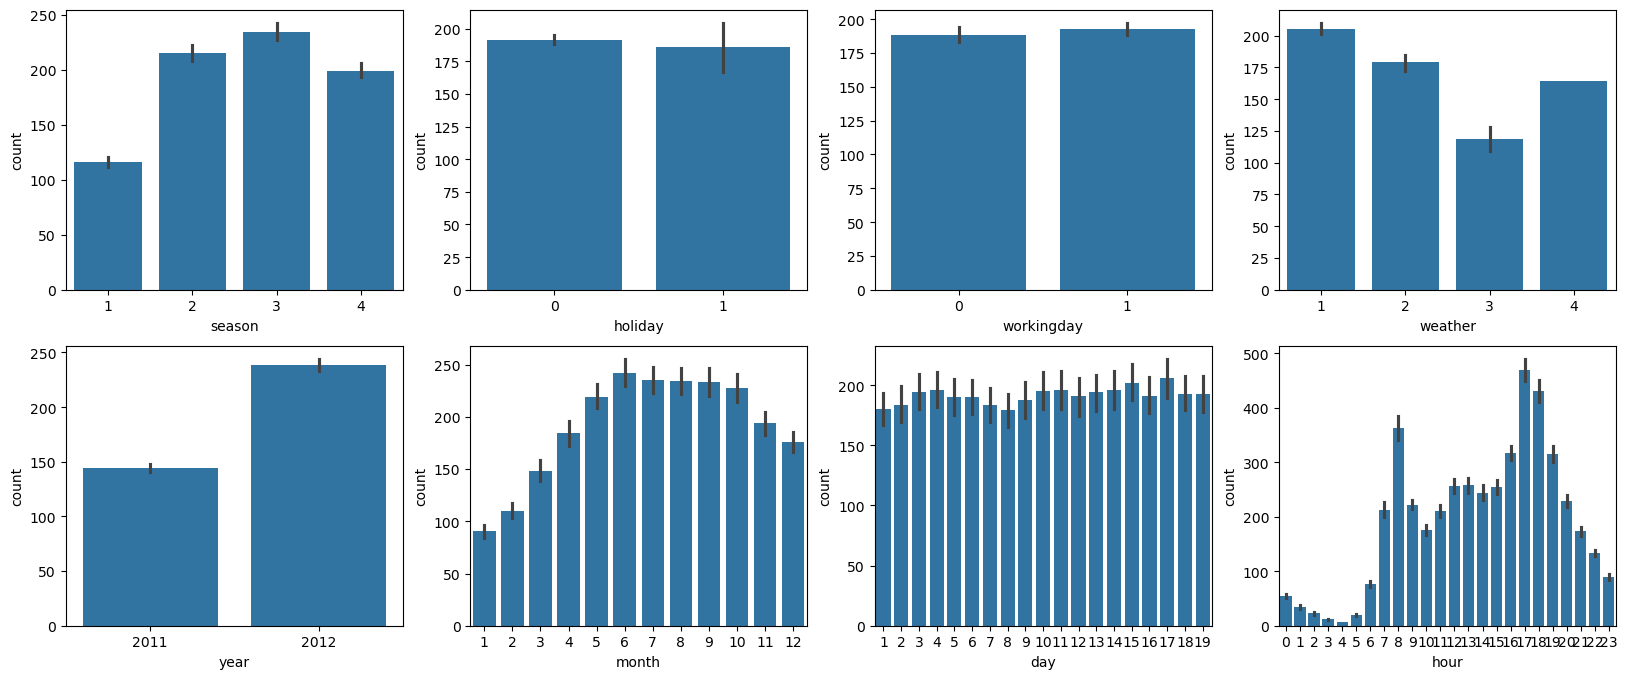

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(figsize=(20, 8), ncols=4, nrows=2)

for i, feature in enumerate(cate):
    row = int(i/4)
    col = i%4
    # 시본의 barplot을 이용해 칼럼값에 따른 count의 합을 표현
    sns.barplot(x=feature, y='count', data=data, ax=axs[row][col])

plt.show() 

이 부분에서 계절의 경우 봄,겨울에 조금 적게 타는 것 같고 휴일과 평일의 차이는 거의 없습니다. 아무래도 휴일에 더 많이 탈것이라고 예측했는데 일단 그렇습니다. 날씨의 경우 3번 날씨가 유독 적게나왔습니다. 년도의 경우 2012년 때 더 많이 카운트 값이 올랐습니다. 달의 경우 계절과 비슷한 양상입니다 겨울에 가장 카운트 값이 적고 여름부터 가을까지 카운트 값을 유지하는것 같습니다. 일의 경우 거의 똑같다고 보겠습니다. 시간은 당연히 새벽에 적게 타고 유독 8시와 17~18시의 카운트 값이 높게 나왔는데 아마 출퇴근 시간에 자전거를 대여하기 때문이 것같습니다. 

연속형 데이터를 regplot 하여 회귀선을 그려서 분석해서 보겠습니다. 

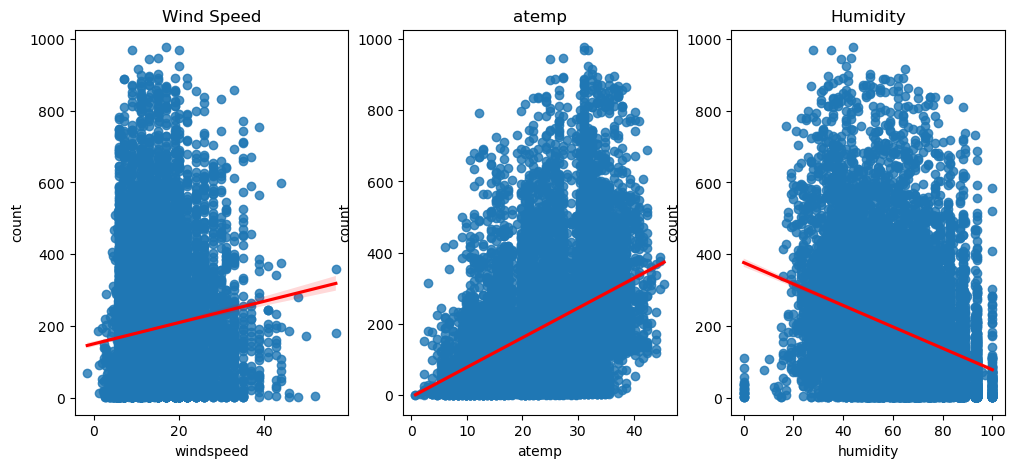

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 5))

sns.regplot(x='windspeed', y='count', data=data, ax=ax1, line_kws={'color': 'red'})

sns.regplot(x='atemp', y='count', data=data, ax=ax2, line_kws={'color': 'red'})

sns.regplot(x='humidity', y='count', data=data, ax=ax3, line_kws={'color': 'red'})

ax1.set_title('Wind Speed')
ax2.set_title('atemp')
ax3.set_title('Humidity')

plt.show()

일다 회귀선 대로 분석해 본다면 풍량은 커질수록 카운트 값이 커지고 체감온도는 커질수록 카운트 값이 커지고 반대로 습도는 커질수록 카운트 값이 작아지는 것 같습니다. 근데 풍량데이터는 회귀선의 분석에 비해 풍량이 0일때의 데이터 량이 유독 많고 풍량이 커질수록 데이터 개수도 적고 카운트 값도 풍량의 커진 값에 비해 커지지 않는 것 같습니다. 3개의 특성중 풍량데이터는 빼고 학습하거나 이상치를 제거하고 학습할 수 있을것 같습니다 

일단 풍량의 특정 부분이 완전 비어있습니다. 풍량의 unique()를 찍어보면 아래와 같습니다. 6.0032 미만의 값이 존재하지 않고 0인 데이터가 많은 것을 보아 아마 결측치를 0으로 채운것 같습니다. 모델을 학습할때 풍량 데이터는 제외하고 하겠습니다.

In [213]:
data['windspeed'].unique()

array([ 0.    ,  6.0032, 16.9979, 19.0012, 19.9995, 12.998 , 15.0013,
        8.9981, 11.0014, 22.0028, 30.0026, 23.9994, 27.9993, 26.0027,
        7.0015, 32.9975, 36.9974, 31.0009, 35.0008, 39.0007, 43.9989,
       40.9973, 51.9987, 46.0022, 50.0021, 43.0006, 56.9969, 47.9988])

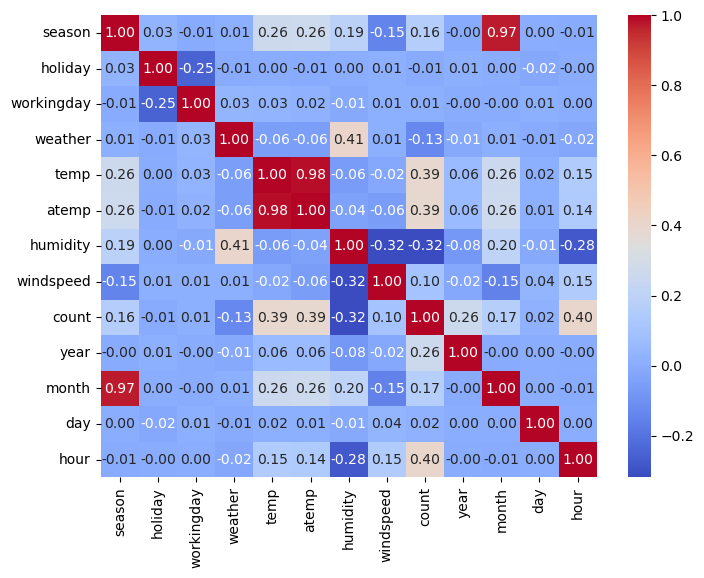

In [100]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot= True, cmap='coolwarm', fmt='.2f')
plt.show()

상관관계 히트맵을 그려봤을때 count와의 상관관계 값이 강한 값을 고르면 시간, 년도, 습도, 체감 온도 정도이고 고려할 만한 특성으로는 달, 계절 정도일것 같습니다다

또한 범주형 데이터들인 ['year', 'month', 'hour', 'holiday', 'workingday','season','weather'] 의 값들은 원 핫 인코딩으로 변환하여 학습하도록 하겠습니다. 이유는 모델이 학습할때 season의 값인 1~4 의 수치를 순서가 있거나 가중치로 보고 학습할 수도 있기때문입니다. 
pd.get_dummies를 사용하겠습니다. 원핫인코딩 모듈을 불러서 하는 방법도 있지만 이 방법이 더 쉽다고 생각합니다. 여기서 day를 하지 않는 이유는 특성으로 쓰지 않기 때문입니다.

In [132]:
data = pd.get_dummies(data, columns=['year', 'month', 'hour', 'holiday','workingday','season','weather']) 
data.columns

Index(['temp', 'atemp', 'humidity', 'windspeed', 'count', 'day', 'year_2011',
       'year_2012', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'holiday_0',
       'holiday_1', 'workingday_0', 'workingday_1', 'season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4'],
      dtype='object')

테스트 데이터를 학습 데이터와 똑같기 하기 위한 전처리 과정입니다.   

In [133]:
test = pd.read_csv(r"C:\Users\302-28\git-repo\Dacon\kaggle\바이크\bike-sharing-demand\test.csv")

test['datetime'] = test.datetime.apply(pd.to_datetime) 

test['year'] = test.datetime.apply(lambda x : x.year)
test['month'] = test.datetime.apply(lambda x : x.month)
test['day'] = test.datetime.apply(lambda x : x.day)
test['hour'] = test.datetime.apply(lambda x: x.hour)
test.drop('datetime', axis = 1, inplace= True)
test.drop(['windspeed', 'day'], axis= 1, inplace= True)
test = pd.get_dummies(test, columns=['year', 'month', 'hour','holiday', 'season','workingday','weather']) 


In [161]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

y = data['count']
X = data.drop(['count','windspeed','day'], axis= 1)

xgb = XGBRegressor()

cross_score= cross_val_score(xgb, X, y, cv= 5)

xgb.fit(X, y)

print(f'교차 검증 점수: {cross_score}, 교차 검증 평균: {np.mean(cross_score)}')

result = xgb.predict(test)

print(result)

교차 검증 점수: [0.3796379  0.86753881 0.77459091 0.87560397 0.85793519], 교차 검증 평균: 0.7510613560676574
[ 12.136767    -2.1328356   -0.75031555 ... 125.235085    92.07656
  55.084755  ]


회귀 값중에 음수 값이 존재합니다. 자전거 대여수가 마이너스가 될수 없으니 로그 값을 이용해 계산합니다.

In [206]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

y = np.log1p(data['count']) # 로그 계산산
X = data.drop(['count','windspeed','day'], axis= 1)

xgb = XGBRegressor()

cross_score= cross_val_score(xgb, X, y, cv= 5)

xgb.fit(X, y)

print(f'교차 검증 점수: {cross_score}, 교차 검증 평균: {np.mean(cross_score)}')

result = xgb.predict(test)

result = np.expm1(result)

sm = pd.read_csv(r"C:\Users\302-28\git-repo\Dacon\kaggle\바이크\bike-sharing-demand\sampleSubmission.csv")

sm['count'] = result

sm.to_csv('xgb_rm_wind_day.csv', index= False)

교차 검증 점수: [0.77164373 0.93166897 0.91060585 0.93051031 0.9192828 ], 교차 검증 평균: 0.8927423341059134


위의 코드의 경우 제출 점수가 0.41350 입니다. 한번 gridsearchcv를 사용해 하이퍼파라미터를 조절하겠습니다.

In [258]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],  # 트리의 수
    'learning_rate': [0.01, 0.05, 0.1],  # 학습률
    'max_depth': [3, 5, 7],  # 트리 깊이
    'subsample': [0.8, 0.9, 1.0]  # 데이터 샘플링 비율
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# 그리드 서치 실행
grid_search.fit(X, y)

# 최적의 파라미터 출력
print("최적의 파라미터:", grid_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
최적의 파라미터: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


In [40]:
data.columns

Index(['temp', 'atemp', 'humidity', 'windspeed', 'count', 'year_2011',
       'year_2012', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'holiday_0',
       'holiday_1', 'workingday_0', 'workingday_1', 'season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4'],
      dtype='object')


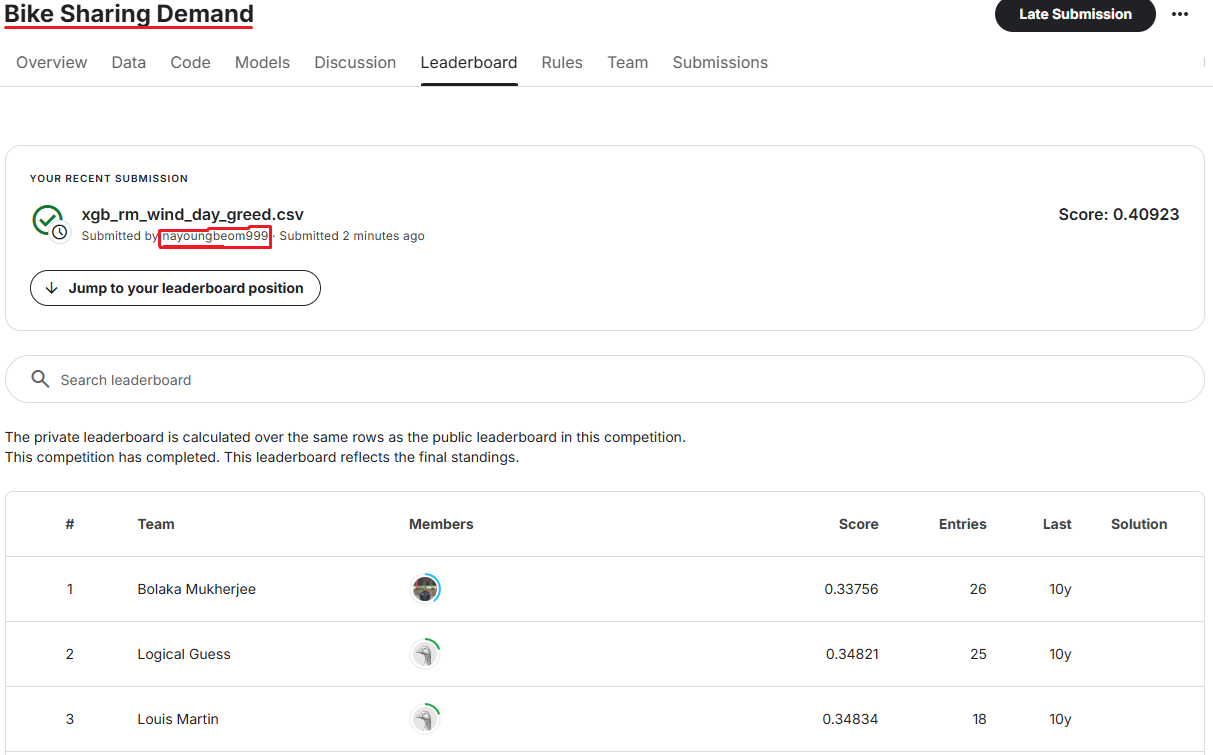

In [265]:
from IPython.display import display, HTML
import base64

image_path = r"C:\Users\302-28\Desktop\1.png"

with open(image_path, "rb") as img_file:
    img_data = img_file.read()
    img_base64 = base64.b64encode(img_data).decode('utf-8')


html_code = f'<img src="data:image/png;base64,{img_base64}" />'
display(HTML(html_code))


위의 코드의 점수는 0.40923입니다. 성능이 약간 올랐습니다.

풍량 데이터와 day 데이터를 제외하고 학습후 greedsearchcv하여 제출한것이 가장 점수가 좋았지만 0.3 대 점수로 들어가진 못했습니다. 여기선 앞서 제외한 풍량데이터를 일단 제 생각대로 채워보겠습니다.

In [7]:
from sklearn.ensemble import RandomForestRegressor

data = pd.read_csv(r"C:\Users\302-28\git-repo\Dacon\kaggle\바이크\bike-sharing-demand\train.csv")

풍량 데이터는 6이하의 값을 제외하기전 10886개가 존재했고 제외 후 9573개가 존재합니다.

In [8]:
data['windspeed']

0         0.0000
1         0.0000
2         0.0000
3         0.0000
4         0.0000
          ...   
10881    26.0027
10882    15.0013
10883    15.0013
10884     6.0032
10885     8.9981
Name: windspeed, Length: 10886, dtype: float64

In [9]:
data = data[data['windspeed'] > 6.0]

In [10]:
data['windspeed']

5         6.0032
10       16.9979
11       19.0012
12       19.0012
13       19.9995
          ...   
10881    26.0027
10882    15.0013
10883    15.0013
10884     6.0032
10885     8.9981
Name: windspeed, Length: 9573, dtype: float64

풍량의 예측값을 구할려는 것이기 때문에 풍량과 관계가 있다고 생각하는 특성들인  season ,weather, humidity 값들로 예측해보겠습니다.

In [110]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

data = pd.read_csv(r"C:\Users\302-28\git-repo\Dacon\kaggle\바이크\bike-sharing-demand\train.csv")

X = data[data['windspeed'] > 6.0][['season', 'weather', 'humidity','temp','atemp']]
y = data[data['windspeed'] > 6.0]['windspeed']

test = data[data['windspeed'] < 6.0][['season', 'weather', 'humidity','temp','atemp']]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_wind = XGBRegressor()
xgb_wind.fit(train_X, train_y)

result = xgb_wind.predict(test)

예측한 값들을 원래의 데이터의 풍량값에 넣습니다.

In [111]:
data.loc[data['windspeed'] < 6.0, 'windspeed'] = result

밑은 회귀를 위한 훈련,테스트 데이터 전처리입니다.

In [112]:
data.drop(['casual','registered'], axis = 1, inplace= True)
data['datetime'] = data.datetime.apply(pd.to_datetime) 
data['year'] = data.datetime.apply(lambda x : x.year)
data['month'] = data.datetime.apply(lambda x : x.month)
data['day'] = data.datetime.apply(lambda x : x.day)
data['hour'] = data.datetime.apply(lambda x: x.hour)
data.drop(['datetime', 'day'], axis = 1, inplace= True)
data = pd.get_dummies(data, columns=['year', 'month', 'hour','holiday', 'season','workingday','weather']) 

In [113]:
test = pd.read_csv(r"C:\Users\302-28\git-repo\Dacon\kaggle\바이크\bike-sharing-demand\test.csv")

test['datetime'] = test.datetime.apply(pd.to_datetime) 

test['year'] = test.datetime.apply(lambda x : x.year)
test['month'] = test.datetime.apply(lambda x : x.month)
test['day'] = test.datetime.apply(lambda x : x.day)
test['hour'] = test.datetime.apply(lambda x: x.hour)
test.drop('datetime', axis = 1, inplace= True)
test.drop('day', axis= 1, inplace= True)
test = pd.get_dummies(test, columns=['year', 'month', 'hour','holiday', 'season','workingday','weather']) 


In [114]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

y = np.log1p(data['count']) # 로그 계산산
X = data.drop(['count'], axis= 1)

scale = StandardScaler()

X = scale.fit_transform(X)
test = scale.transform(test)

xgb = XGBRegressor(learning_rate= 0.1, max_depth= 7, n_estimators= 200, subsample= 0.8)

cross_score= cross_val_score(xgb, X, y, cv= 5)

xgb.fit(X, y)

print(f'교차 검증 점수: {cross_score}, 교차 검증 평균: {np.mean(cross_score)}')

result = xgb.predict(test)

result = np.expm1(result)

sm = pd.read_csv(r"C:\Users\302-28\git-repo\Dacon\kaggle\바이크\bike-sharing-demand\sampleSubmission.csv")

sm['count'] = result

sm.to_csv('xgb_rm_wind_day_greed.csv', index= False)

교차 검증 점수: [0.76366315 0.93791407 0.91073378 0.93746299 0.92096147], 교차 검증 평균: 0.8941470919936598


windspeed를 아예 안쓴 똑같은 모델의 점수보다 낮게 나왔습니다. 아무래도 예측할때 사용한 특성이 너무 적어서 아니면 잘못된 특성을 선택해서 회귀가 잘 안된것같습니다. weather같은 범주형 데이터를 원핫인코딩 하고싶었지만 하다보니 풍량이 6 미만인 것 중에 weather이 4인 값이 아예 없어 사용하지 못했습니다.

앞서 day 특성은 제외하고 학습하였으나 강사님이 주신 힌트를 참고하여여 모델이 시계열 데이터에 대해 학습할 때 시간의 흐름과 패턴에 대해 학습한다고 알게되어서 day 특성을 이용해 보겠습니다. 하지만 학습 데이터의 경우 1~19일 테스트 데이터의 경우 20일에서 말일 까지라서 학습을 시도했을때 특성이 맞지 않아 오류가 나왔었는데 그걸 고치기 위해 시계열 전처리중에 dt.weekday 를 사용해 요일로 해보겠습니다 .

요일과 카운트의 시각화 하여 분석해 보았을때 day처럼 일정해 보입니다. 시계열 데이터가 아닌 데이터 였다면 학습 특성으로 사용하지 않았을것 같습니다.

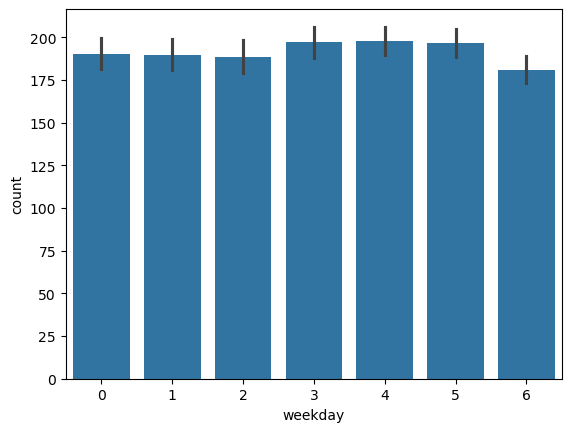

In [125]:
data = pd.read_csv(r"C:\Users\302-28\git-repo\Dacon\kaggle\바이크\bike-sharing-demand\train.csv")
data['datetime'] = pd.to_datetime(data['datetime'])
data['weekday'] = data['datetime'].dt.weekday
sns.barplot(x= 'weekday', y= 'count', data = data)
plt.show()

아래 코드는 위의 xgb 모델 코드와 데이터 전처리 함수를 만들어 합쳤습니다. 전처리를 함수화 하지 않고 사용하다보니 여간 귀찮은게 아니고 순서때문에 오류도 자주 나서 함수화 했습니다. 위들의 코드와 다른점은 weekday 특성을 만들어서 학습하는 부분입니다.

In [138]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

data = pd.read_csv(r"C:\Users\302-28\git-repo\Dacon\kaggle\바이크\bike-sharing-demand\train.csv")
test = pd.read_csv(r"C:\Users\302-28\git-repo\Dacon\kaggle\바이크\bike-sharing-demand\test.csv")

def wind_fix(df):
    
    df.loc[df['windspeed'] < 6.0, 'windspeed'] = df[df['windspeed'] > 6].median()

    return df

# 데이터 전처리 함수 정의
def preprocess_data(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.weekday # 요일특성을 추가
    df.drop(['datetime', 'day'], axis=1, inplace=True)
    df = pd.get_dummies(df, columns=['year', 'month', 'hour', 'holiday', 'workingday', 'season', 'weather', 'weekday']) 
    return df

data = preprocess_data(data)
test = preprocess_data(test)

y = np.log1p(data['count'])  
X = data.drop(['count','casual','registered'], axis=1)

xgb = XGBRegressor(learning_rate= 0.1, max_depth= 7, n_estimators= 200, subsample= 0.8)

cross_score = cross_val_score(xgb, X, y, cv= 5)

xgb.fit(X, y)

result = xgb.predict(test) 

result = np.expm1(result)  

print(f'교차 검증 : {cross_score}, 교차 검증 평균점수 : {np.mean(cross_score)}')

sm = pd.read_csv(r"C:\Users\302-28\git-repo\Dacon\kaggle\바이크\bike-sharing-demand\sampleSubmission.csv")

sm['count'] = result

sm.to_csv('real_xgb.csv', index=False)

교차 검증 : [0.77738101 0.93996219 0.91377403 0.94450781 0.92399232], 교차 검증 평균점수 : 0.8999234722097293



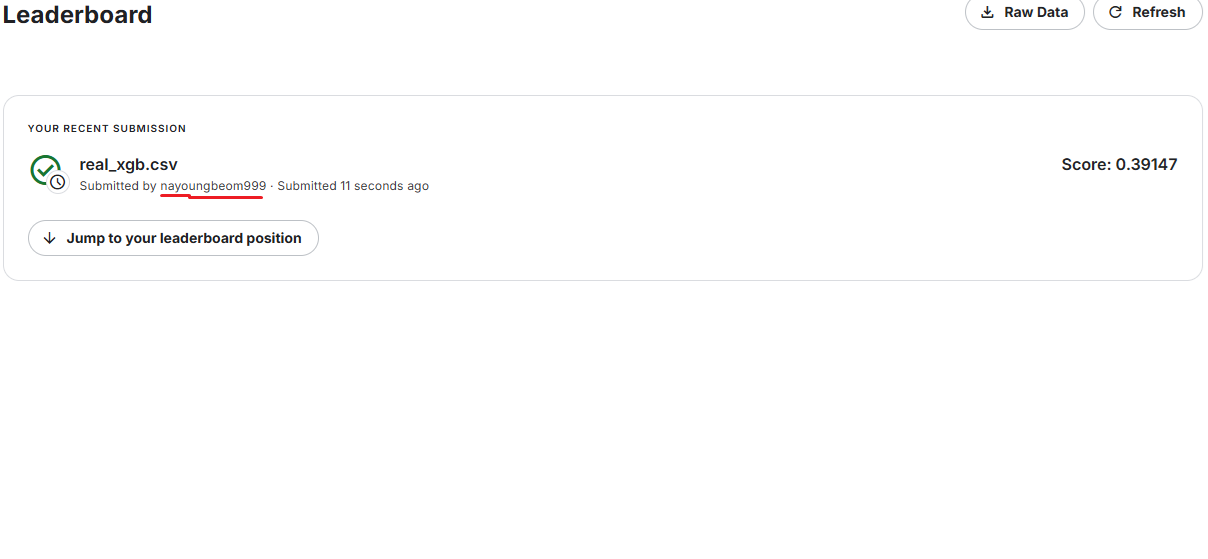

In [135]:
from IPython.display import display, HTML
import base64

image_path = r"C:\Users\302-28\Desktop\22222222.png"

with open(image_path, "rb") as img_file:
    img_data = img_file.read()
    img_base64 = base64.b64encode(img_data).decode('utf-8')


html_code = f'<img src="data:image/png;base64,{img_base64}" />'
display(HTML(html_code))
